# Tracking Beam Center Drift

This notebook is used to track beam drifting over time by viewing the center value with respect to time of collection (e.g, lab time). No other data processing is done in this notebook. Used only as an analytical tool to help with diagnostics and future noise reduction

## Global Variable Usage
The package `gued.py` relies on a few global variables which should be optimized for each experiment. The global variables are stored in `gued_globals.py` and follow standard formatting of all caps (i.e., CENTER_GUESS = (470, 450)). 

In [1]:
%%writefile gued_globals.py
### Global Variables for s1 data set

# Variable for reading files
SEPARATORS = ['-', '_']

# Variables for Center Finding Algorithm
CENTER_GUESS = (460, 460)
RADIUS_GUESS = 35
DISK_RADIUS = 3

# Variable for Generating Background
CORNER_RADIUS = 20
CHECK_NUMBER = 50

# Variables for Masking
MASK_CENTER = [475, 475]
MASK_RADIUS = 40
ADDED_MASK = [[440, 435, 40]]

# Used throughout code as the threshold for cutting out date. This is the default value but other values can be set for the functions using
# std_factor = 4
STD_FACTOR = 3

# Specifies the maximum number of workers to be used when running concurrent.futures
MAX_PROCESSORS = 6

# Adjust figure size 
FIGSIZE = (12,4)

# Path for Theory Package

PATH_DCS = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\Coding Lab Notebook\\gued_package\\GUED_Analysis\\packages\\dcs_repositiory\\3.7MeV\\'
#path_dcs = '/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/dcs_repository/3.7MeV/


Overwriting gued_globals.py


## Import necessary Packages

In [2]:
# Standard Packages
import numpy as np
import glob
import matplotlib.pyplot as plt
from datetime import date


# new code 
import gued

#interactive plotting 
%matplotlib widget

### Defining path -- Uses * to make more accessible for reading in multiple scan files

In [3]:
data_path = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\nitrophenyl code\\20180823\\Run\\*\\'
#data_path = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\nitrophenyl code\\20180623\\Run\\'
run_path = "*\\*\\ANDOR1_*.tif"


bkg_path = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Background/*/*/ANDOR1_*.tif'


full_path = data_path + run_path
#full_path = "D:\\UED_Data\\CP Images\\ANDOR1_*.tif"
print(full_path)
print(bkg_path)

files = glob.glob(full_path) 
bkg_files = glob.glob(bkg_path)
print(len(files))
print(len(bkg_files))

C:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\nitrophenyl code\20180823\Run\*\*\*\ANDOR1_*.tif
/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Background/*/*/ANDOR1_*.tif
1998
0


### Reading in All Data and Getting Total Counts

In [4]:
help(gued.get_image_details)

Help on function get_image_details in module gued:

get_image_details(file_names, sort=True, filter_data=False, plot=False)
    Reads all images from input file_names and returns the data as a 3d array along with stage positions, order, and counts per image.
    
    ARGUMENTS:
    
    file_names (list):
        list of file names to be read in
    
    OPTIONAL ARGUMENTS:
    
    sort (boolean): 
        default is set to True. This arguments sorts the data based on when it was saved (i.e. file number)
    plot (boolean): 
        default is set to False. When True, a plot of the data, log(data), and histogram of counts is shown
    filter_data (boolean or list): 
        default is set to False. If you want to select only a fraction of the images, set filter_data = [min_image,]
    
    GLOBAL VARIABLES:
    
    SEPARATORS (list):
        list of strings such as '_' or '-' which are used in the file naming scheme to separate values needed for data analysis (i.e. stage
        posi

Loading diffraction signal


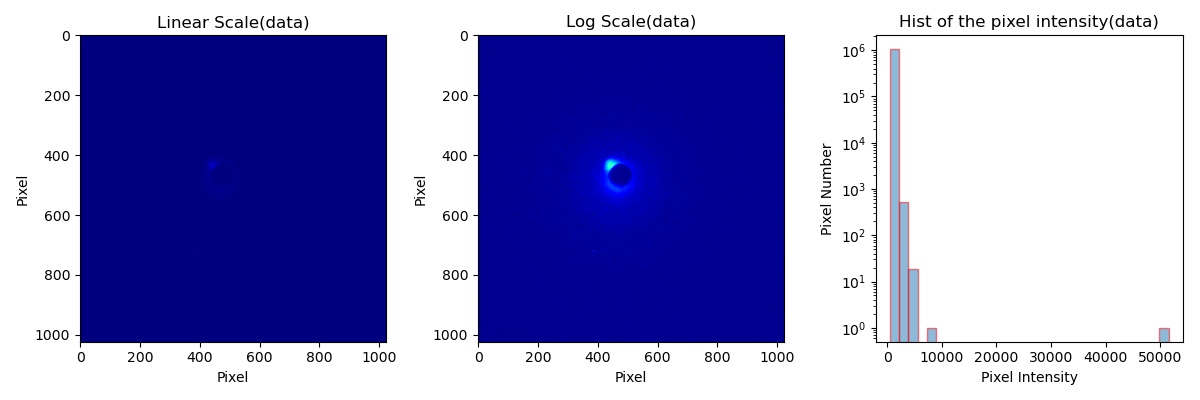

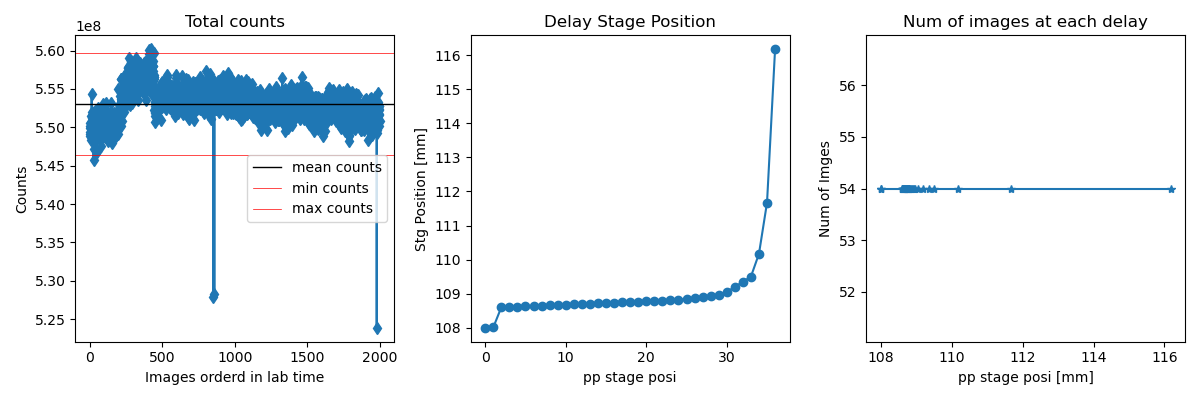

In [5]:
print('Loading diffraction signal');
data_array, stage_positions, file_numbers, counts = gued.get_image_details(files[:], sort=True, filter_data=False, plot=True)

center_ave = np.mean(counts)        # Mean values of Total Counts of all images
center_std  = np.std(counts)         # the STD of all the tc for all the iamges
uni_stage = np.unique(stage_positions)# Pump-probe stage position


## Averaging Based on Image Number

To reduce amount of data being processed and increase the reliability of center finding, create groups of different image sizes to average together. Recommended group size is 1% to 2.5% of data (i.e., if I have 2000 images I would pick a group size between 20-50 images per group)

In [6]:
grp_sz = 100
groups = np.arange(0, len(file_numbers)+1, grp_sz)
data_groups = []
for i in range(len(groups)-1):
    ave_data = np.mean(data_array[groups[i]:groups[i+1]], axis=0)
    print("Averaging group: ", groups[i], "-", groups[i+1])
    data_groups.append(ave_data)
    
data_groups = np.array(data_groups)
print(data_groups.shape)

#ave_counts = gued._get_counts(data_groups, plot=True)

Averaging group:  0 - 100
Averaging group:  100 - 200
Averaging group:  200 - 300
Averaging group:  300 - 400
Averaging group:  400 - 500
Averaging group:  500 - 600
Averaging group:  600 - 700
Averaging group:  700 - 800
Averaging group:  800 - 900
Averaging group:  900 - 1000
Averaging group:  1000 - 1100
Averaging group:  1100 - 1200
Averaging group:  1200 - 1300
Averaging group:  1300 - 1400
Averaging group:  1400 - 1500
Averaging group:  1500 - 1600
Averaging group:  1600 - 1700
Averaging group:  1700 - 1800
Averaging group:  1800 - 1900
(19, 1024, 1024)


## Find Centers

First, adjust global variables using the `Set_up_Globals.ipynb` notebook to get centers accurately. Should not see center jumps more than one or two pixels. If this is happening you probably need to adjust global values

In [7]:
help(gued.find_center_pool)

Help on function find_center_pool in module gued:

find_center_pool(data_array, plot=True, print_stats=True)
    Finds center of each image in the data array using concurrent.futures.ThreadPoolExecutor to quickly process
    many data files.
    
    ARGUMENTS:
    
    data_array (ndarray): 
        array of image like data with shape Nx1024x1024
    
    OPTIONAL ARGUMENTS:
    
    plot (boolean): 
        Default is set to True. When true, plots an image of the values for center_x and center_y with respect to pixel number
    print_stats (boolean): 
        Default is set to True. Prints the average value for center_x and center_y and prints the percent failure rate.
    
    GLOBAL VARIABLES:
    
    CENTER_GUESS (tuple): 
        initial guess for center position
    RADIUS_GUESS (int): 
        initial guess for the radius
    DISK_RADIUS (int): 
        value for disk radius used in mapping
    
    RETURNS:
    
    center_x (array):
        One-dimensional array of x values 

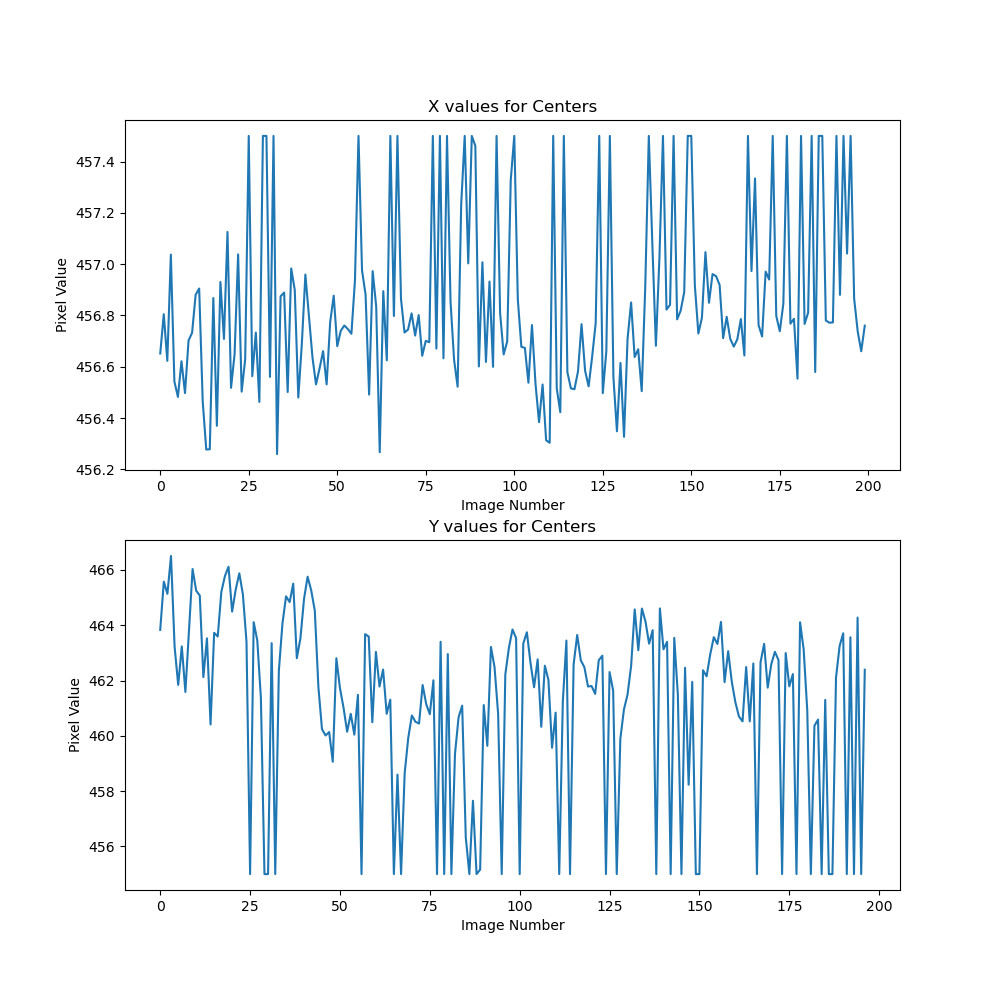

Averaged ctr is (456.8545652511283, 461.193352959545)
Percentage of images where the center finding failed (i.e., found the guess value): 0.0


In [10]:
center_x, center_y = gued.find_center_pool(data_array[400:600], plot=True)
centers = list(zip(center_x, center_y))

## Testing Development

(194,)
19042
6  number of files removed from  200  initial files


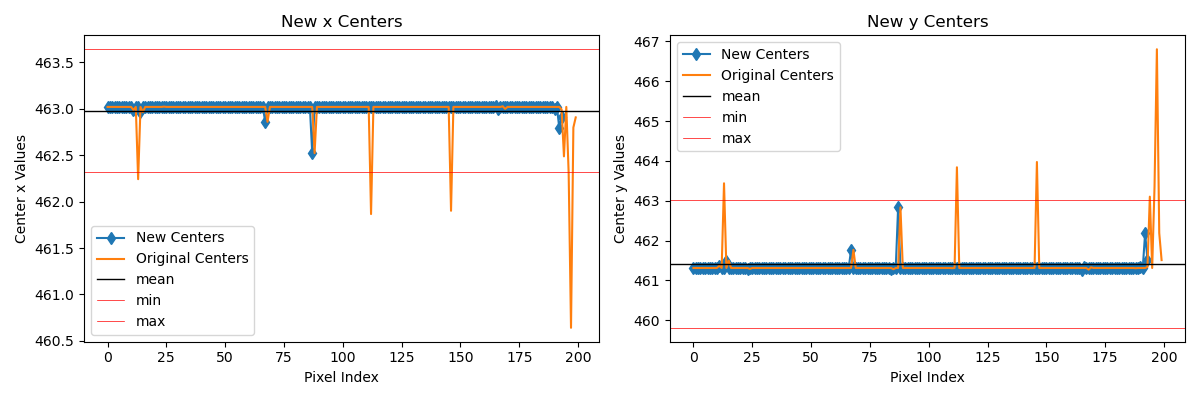

In [32]:
new_data, new_stages, new_centers = gued.remove_based_on_center(centers, data_array[0:400], stage_positions[0:400], plot=True)